In [1]:
import time
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from copy import deepcopy

In [2]:
def GraphPainter(G, mode = 'ABshare'):
    color = []
    if mode == 'ABshare':
        for idx in range(len(G.node)):
            if(G.node[idx]['type'] == 'A' and G.node[idx]['share'] == 1):
                color.append('red')
            elif(G.node[idx]['type'] == 'B' and G.node[idx]['share'] == 1):
                color.append('yellow')
            elif(G.node[idx]['type'] == 'A' and G.node[idx]['share'] == 0):
                color.append('blue')
            else:
                color.append('black')
    elif mode == 'AB':
        for idx in range(len(G.node)):
            if(G.node[idx]['type'] == 'A'):
                color.append('red')
            else:
                color.append('black')
    elif mode == 'share':
        for idx in range(len(G.node)):
            if(G.node[idx]['share'] == 1):
                color.append('red')
            else:
                color.append('black')
    else:
        color = ['black'] * len(G.node)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_label = False, node_color = color, node_size = 150)
    plt.show()

def lineChartPainter(res, save_file = True):
    marker = ['*', 'o', '>', '<', '^', 'v', '1', '2','3','4','8','s','p','h','+', 'x','d']
    x = range(len(res[0]))
    for i in range(len(res)):
        label = "P" + str(i + 1)
        if save_file:
            plt.plot(x, res[i], label = label, marker = marker[int(i % len(marker))],markevery = list(range(0,len(res[0]), 5)))
        else:
            plt.plot(x, res[i])
    plt.title("Result")
    plt.xlabel("Time")
    plt.ylabel("The proportion of nodes choose to share")
    plt.legend()
    name = time.strftime("%Y-%m-%d-%H_%M_%S",time.localtime(time.time()))  + r".jpg"
    #name = "result.jpg"
    if save_file:
        plt.savefig(name, dpi = 1800)
    else:
        plt.show()
        

In [3]:



def doSimulation(parameters, times, max_time = 100):
    res = []
    #print(parameters)
    for i in range(len(parameters)):
        network = parameters[i][0]
        division = parameters[i][1]
        game = parameters[i][2]
        m = matrixInit(game, network[0])
        
        tmp = []
        res.append([])
        for j in range(times):
            G = networkCreate(network[0], network[1], network[2], network[3], division)
            tmp.append([])
            for k in range(max_time):
                if k > 0 and (tmp[j][k - 1] == 0 or tmp[j][k - 1] == 1):
                    tmp[j].append(tmp[j][k - 1])
                else:
                    tmp[j].append(proportionOfShare(G))
                    G = networkUpdate(G, m, game[0])
                if k == max_time - 1:
                    GraphPainter(G)
            print("%.3f%%" %((i*times + j + 1)/(len(parameters) * times) * 100))
        for j in range(max_time):
            res[i].append(round(np.mean([tmp[k][j] for k in range(times)]), 3))
    return res
        
        
        
    

In [4]:

def networkCreate(total_node, average_degree, network_type, k, division_parameter):
    '''
    division_parameter:
        0:
            0 for divide by degree
            1 for divide randomly
        1:
            the proportion of node A in division
        2:
            the probability type-A nodes choose to share
        3:
            the probability type-B nodes choose to share
    '''
    if len(division_parameter) != 4 :
        print("parameter numbers error!")
    else:
        if network_type == "ws":
            G = nx.random_graphs.watts_strogatz_graph(total_node, average_degree, k)
        else:
            G = nx.random_graphs.barabasi_albert_graph(total_node, int(average_degree/2))
        degree = [i[1] for i in nx.degree(G)]
        division_arr = list(range(total_node))
        if division_parameter[0]:
            random.shuffle(division_arr)
        else:
            division_arr.sort(key = lambda d:degree[d])
        typeB = division_arr[:int(total_node * (1 - division_parameter[1]))]
        typeA = division_arr[int(total_node * (1 - division_parameter[1])):]
        random.shuffle(typeA)
        random.shuffle(typeB)
        share = typeA[:int(len(typeA) * division_parameter[2])] + typeB[:int(len(typeB) * division_parameter[3])]
        for idx in range(len(G.node)):
            if idx in typeA:
                G.node[idx]['type'] = 'A'
            else:
                G.node[idx]['type'] = 'B'
            if idx not in share:
                G.node[idx]['share'] = 0
            else:
                G.node[idx]['share'] = 1
        return G
def networkInfo(G):
    num_of_nodes = len(G.node)
    num_of_share_A = 0
    num_of_share_B = 0
    num_of_A = 0
    num_of_B = 0
    for idx in range(len(G.node)):
        if G.node[idx]['type'] == 'A':
            num_of_A += 1
            if(G.node[idx]['share']):
                num_of_share_A += 1
        else:
            num_of_B += 1
            if(G.node[idx]['share']):
                num_of_share_B +=1
    average_degree = np.mean([i[1] for i in G.degree()])
    print("The number of nodes is %d" %num_of_nodes)
    print("There are %d A nodes and %d B nodes" %(num_of_A,num_of_B))
    print("And %d A nodes and %d B nodes choose to share" %(num_of_share_A,num_of_share_B))
    print("The average degree is %lf" %average_degree)
def proportionOfShare(G):
    num_of_share = 0
    for idx in range(len(G.node)):
        if G.node[idx]['share']:
            num_of_share += 1
    return num_of_share / len(G.node)
            

In [5]:

def matrixInit(p, n):
    kappa,K1,K2,a1,a2,b1,b2,t1,t2,w1,w2,f1,f2,c1,c2 = p
    res = []
    A1 = (1 + t1) * a1 * K1 * b1 + w1 * a1 * K1 - c1 * a1 * K1 / (n - 1)
    B1 = w1 * a1 * K1 - c1 * a1 * K1 / (n - 1)
    C1 = a1 * K1 * b1
    D1 = 0
    res.append([[A1, A1], [B1, C1], [C1, B1], [D1, D1]])
    A2 = (1 + t1) * a2 * K2 * b1 + w1 * a1 * K1 - c1 * a1 * K1 / (n - 1)
    B2 = w1 * a1 * K1 - c1 * a1 * K1 / (n - 1)
    C2 = a2 * K2 * b1
    D2 = 0
    E1 = (1 + t2) * a1 * K1 * b2 + w2 * a2 * K2 - c2 * a2 * K2 / (n - 1)
    F1 = a1 * K1 * b2
    G1 = w2 * a2 * K2 - c2 * a2 * K2 / (n - 1)
    H1 = 0
    res.append([[A2, E1], [B2, F1], [C2, G1], [D2, H1]])
    A3 = (1 + t1) * a1 * K1 * b1 - c1 * a1 * K1 / (n - 1) - f1 * a1 * K1
    B3 = -1 * c1 * a1 * K1 / (n - 1) - f1 * a1 * K1
    C3 = a1 * K1 * b1
    D3 = 0
    res.append([[A3, A3], [B3, C3], [C3, B3], [D3, D3]])
    A4 = (1 + t1) * a2 * K2 * b1 - c1 * a1 * K1 / (n - 1) - f1 * a1 * K1
    B4 =-1 * c1 * a1 * K1 / (n - 1) - f1 * a1 * K1
    C4 = a2 * K2 * b1
    D4 = 0
    E2 = (1 + t2) * a1 * K1 * b2 - c2 * a2 * K2 / (n - 1) - f2 * a2 * K2
    F2 = a1 * K1 * b2
    G2 = -1 * c2 * a2 * K2 / (n - 1) - f2 * a2 * K2
    H2 = 0
    res.append([[A4, E2], [B4, F2], [C4, G2], [D4, H2]])
    E3 = (1 + t2) * a2 * K2 * b2 + w2 * a2 * K2 - c2 * a2 * K2 / (n - 1)
    F3 = a2 * K2 * b2
    G3 = w2 * a2 * K2 - c2 * a2 * K2 / (n - 1)
    H3 = 0
    res.append([[E3, E3], [G3, F3], [F3, G3], [H3, H3]])
    E4 = (1 + t2) * a2 * K2 * b2 - c2 * a2 * K2 / (n - 1) - f2 * a2 * K2
    F4 = a2 * K2 * b2
    G4 =  -1 * c2 * a2 * K2 / (n - 1) - f2 * a2 * K2
    H4 = 0
    res.append([[E4, E4], [G4, F4], [F4, G4], [H4, H4]])
    for m in res:
        for e in m:
            for i in e:
                round(i, 3)
    return res
    
def actGame(m, c, t1, t2, s1, s2):
    if c == 1:
        if t1 == 'A' and t2 == 'A':
            if s1 == 1 and s2 == 1:
                return m[0][0]
            elif s1 == 1 and s2 == 0:
                return m[0][1]
            elif s1 == 0 and s2 == 1:
                return m[0][2]
            else:
                return m[0][3]
        elif t1 == 'A' and t2 == 'B':
            if s1 == 1 and s2 == 1:
                return m[1][0]
            elif s1 == 1 and s2 == 0:
                return m[1][1]
            elif s1 == 0 and s2 == 1:
                return m[1][2]
            else:
                return m[1][3]
        elif t1 == 'B' and t2 == 'A':
            if s1 == 1 and s2 == 1:
                return m[1][0][::-1]
            elif s1 == 1 and s2 == 0:
                return m[1][2][::-1]
            elif s1 == 0 and s2 == 1:
                return m[1][1][::-1]
            else:
                return m[1][3][::-1]
        else:
            if s1 == 1 and s2 == 1:
                return m[4][0]
            elif s1 == 1 and s2 == 0:
                return m[4][1]
            elif s1 == 0 and s2 == 1:
                return m[4][2]
            else:
                return m[4][3]
    else:
        if t1 == 'A' and t2 == 'A':
            if s1 == 1 and s2 == 1:
                return m[2][0]
            elif s1 == 1 and s2 == 0:
                return m[2][1]
            elif s1 == 0 and s2 == 1:
                return m[2][2]
            else:
                return m[2][3]
        elif t1 == 'A' and t2 == 'B':
            if s1 == 1 and s2 == 1:
                return m[3][0]
            elif s1 == 1 and s2 == 0:
                return m[3][1]
            elif s1 == 0 and s2 == 1:
                return m[3][2]
            else:
                return m[3][3]
        elif t1 == 'B' and t2 == 'A':
            if s1 == 1 and s2 == 1:
                return m[3][0][::-1]
            elif s1 == 1 and s2 == 0:
                return m[3][2][::-1]
            elif s1 == 0 and s2 == 1:
                return m[3][1][::-1]
            else:
                return m[3][3][::-1]
        else:
            if s1 == 1 and s2 == 1:
                return m[5][0]
            elif s1 == 1 and s2 == 0:
                return m[5][1]
            elif s1 == 0 and s2 == 1:
                return m[5][2]
            else:
                return m[5][3]

def strategyChange(G, kappa):
    n = G.number_of_nodes()
    for i in range(n):
        neighborRandom = random.choice(list(G.neighbors(i)))
        u1 = G.node[i]['profit']
        u2 = G.node[neighborRandom]['profit']
        W = 1 / (1 + np.exp((u1 - u2) / kappa))
        #print(i, neighborRandom, u1, u2, W)
        if random.random() <= W:
            G.node[i]['share'] = G.node[neighborRandom]['share']
        
def networkUpdate(G, matrix, kappa):
    tG = deepcopy(G)
    n = G.number_of_nodes()
    for i in range(n):
        tG.node[i]['profit'] = 0
    for i in range(n):
        for j in range(i + 1, n):
            profit = actGame(matrix, j in list(tG.neighbors(i)), tG.node[i]['type'],tG.node[j]['type'] ,tG.node[i]['share'],tG.node[j]['share'])
            #print(j in list(G.neighbors(i)), tG.node[i]['type'],tG.node[j]['type'],tG.node[i]['share'],tG.node[j]['share'], sep = ' ')
            #print(i, j, "[%.3lf, %.3lf]" %(profit[0], profit[1]))
            tG.node[i]['profit'] += profit[0]
            tG.node[j]['profit'] += profit[1]
    strategyChange(tG, kappa)
    return tG
def networkCompare(G1, G2):
    for i in range(G1.number_of_nodes()):
        if G1.node[i]['share'] != G2.node[i]['share']:
            return False
    return True
           
                
        
        
    

E:\anaconda\anaconda\envs\class_IntelligentBigData\lib\site-packages\ipykernel_launcher.py:130: RuntimeWarning: overflow encountered in exp


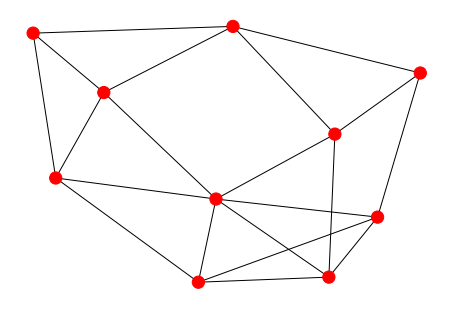

3.333%


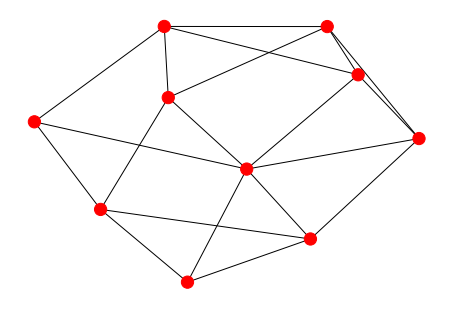

6.667%


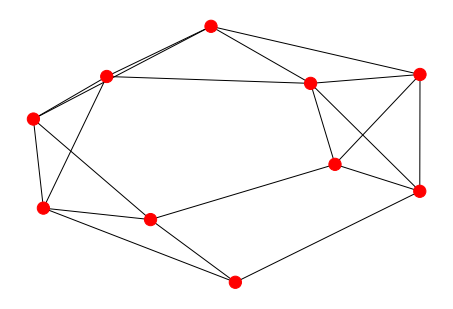

10.000%


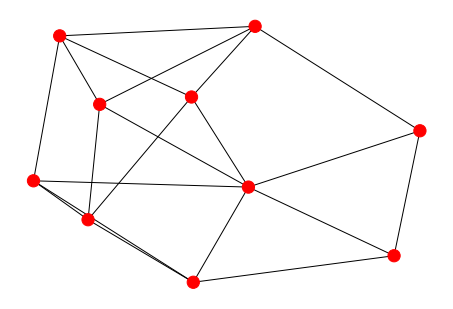

13.333%


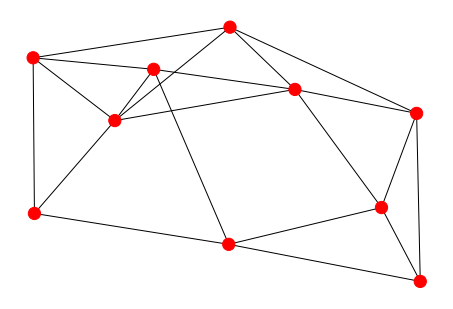

16.667%


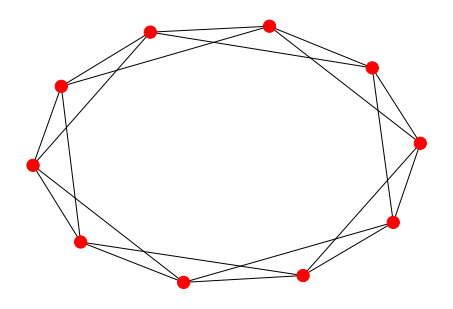

20.000%


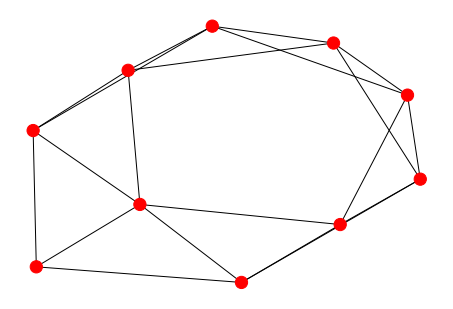

23.333%


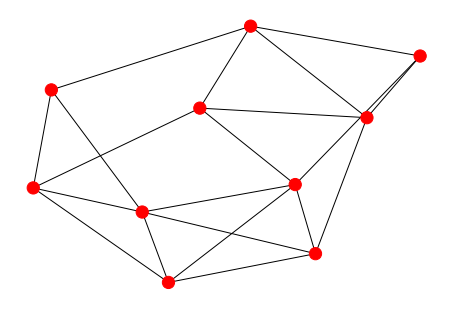

26.667%


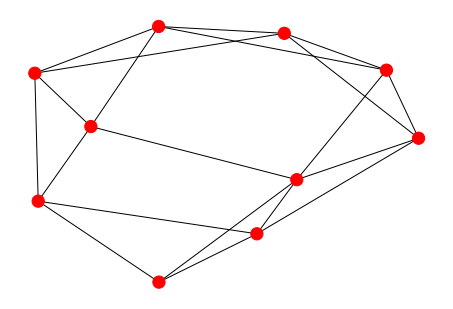

30.000%


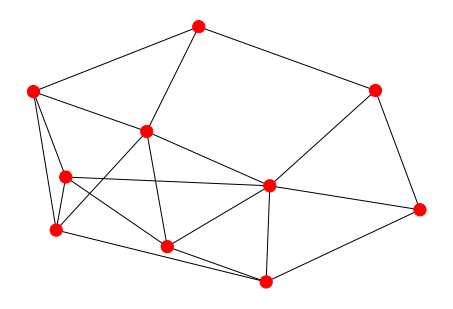

33.333%


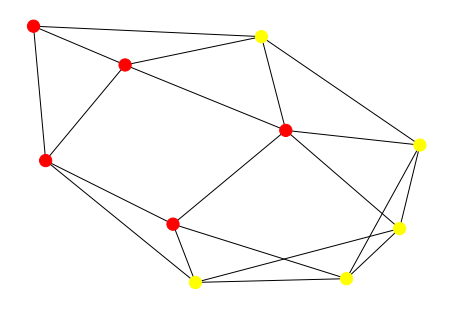

36.667%


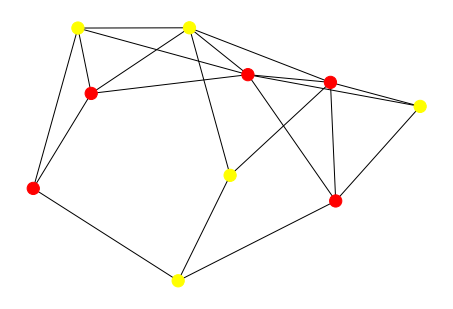

40.000%


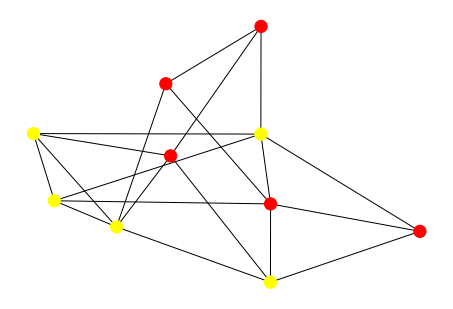

43.333%


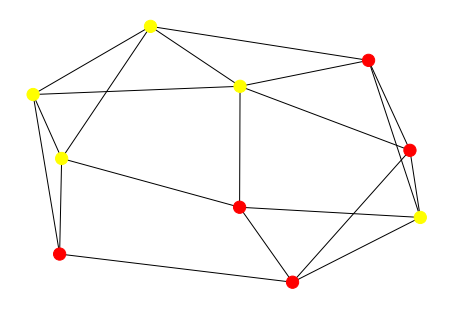

46.667%


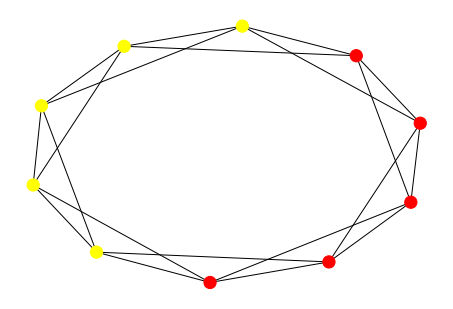

50.000%


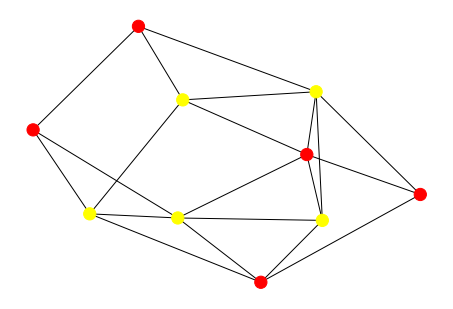

53.333%


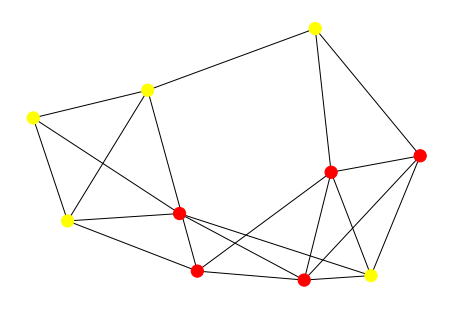

56.667%


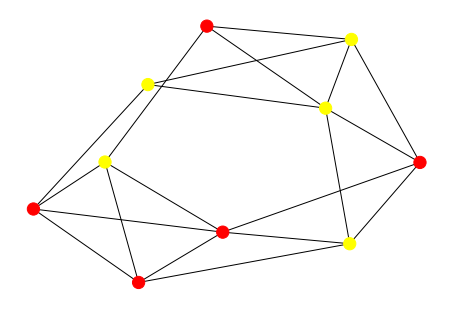

60.000%


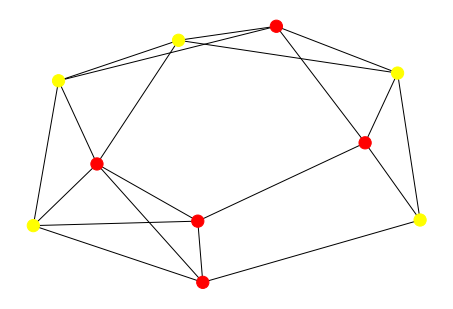

63.333%


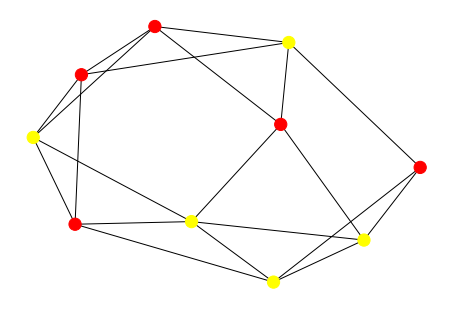

66.667%


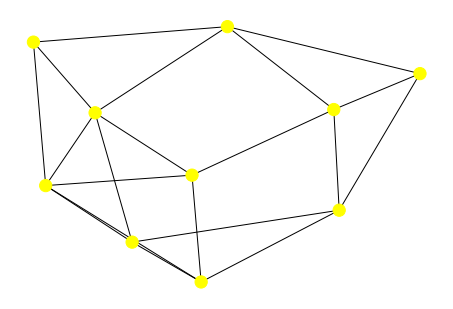

70.000%


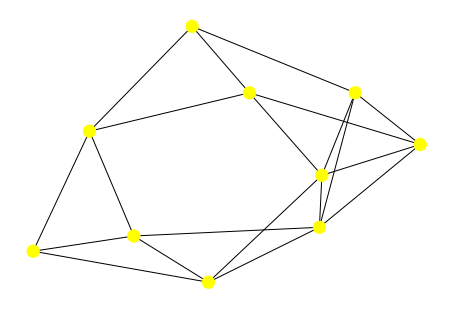

73.333%


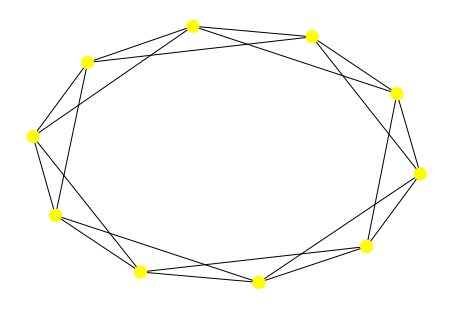

76.667%


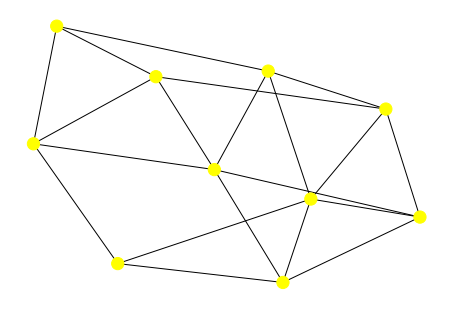

80.000%


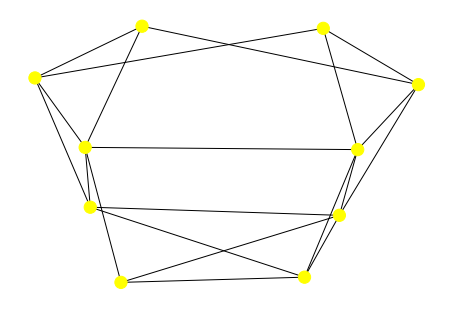

83.333%


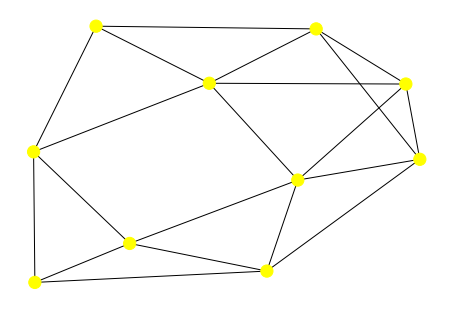

86.667%


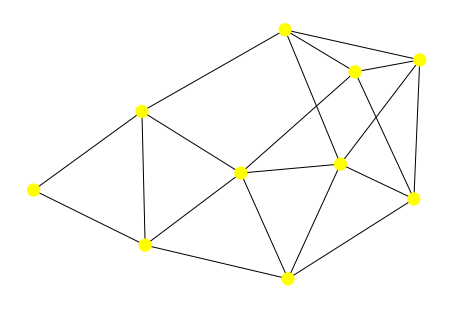

90.000%


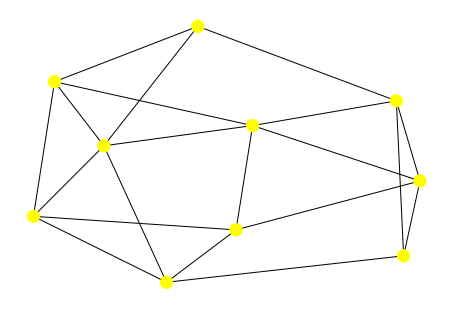

93.333%


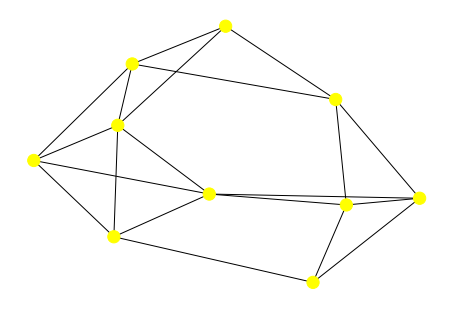

96.667%


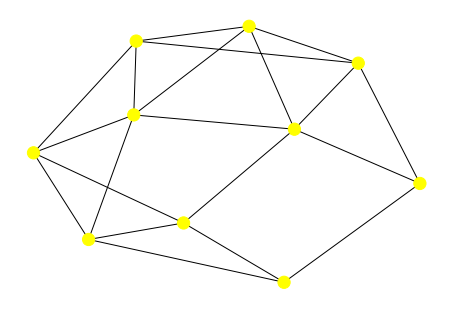

100.000%
[[0.5, 0.84, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.4, 0.44, 0.55, 0.64, 0.8, 0.88, 0.94, 0.98, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

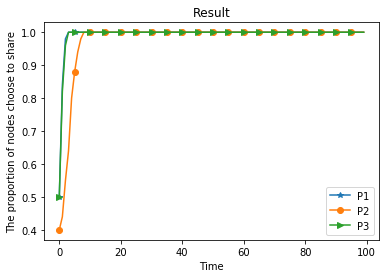

In [6]:
def main():
    parameters = [[[10, 5, 'ws', 0.1], [1, 1.0, 0.5, 0.5],[0.001 ,5, 1, 0.5, 0.5, 0.8, 0.8, 0.8, 0.8, 0.4, 0.4, 0.3, 0.3, 0.5, 0.5]],
                  [[10, 5, 'ws', 0.1], [1, 0.5, 0.5, 0.5],[0.001 ,5, 1, 0.5, 0.5, 0.8, 0.8, 0.8, 0.8, 0.4, 0.4, 0.3, 0.3, 0.5, 0.5]],
                  [[10, 5, 'ws', 0.1], [1, 0.0, 0.5, 0.5],[0.001 ,5, 1, 0.5, 0.5, 0.8, 0.8, 0.8, 0.8, 0.4, 0.4, 0.3, 0.3, 0.5, 0.5]]]
    start = time.clock()
    res = doSimulation(parameters, 10)
    finish = time.clock()
    print(res)
    print(str(finish - start))
    lineChartPainter(res)

if __name__ == '__main__':
    main()